In [124]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [159]:
data_meta = pd.read_csv('/kaggle/input/content-based/meta_full_csv')
data_meta = data_meta.sample(50000)
data_meta['summaryRev'] = data_meta["summary"] + " " + data_meta["reviewText"] 

In [160]:
data_meta

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,description,category,summaryRev
373630,5.0,True,"06 10, 2012",A1BOXO97YQTFGX,B004SL30RC,{'Size:': ' Pro Set'},ROBrob,Bought 2 of these because of the price. Love t...,great product,1339286400,['Kit Includes nutsetters and black oxide dril...,"['Tools & Home Improvement', 'Power & Hand Too...",great product Bought 2 of these because of the...
255628,5.0,True,"03 7, 2004",A3UDYY6L2NH3JS,6303122647,{'Format:': ' VHS Tape'},Dr Jacques COULARDEAU,The Story itself is a perverse well ending dis...,"Christmas is better than Halloween, but Hallow...",1078617600,['Disney and Touchstone team up with Tim Burto...,"['Movies & TV', 'Science Fiction & Fantasy', '...","Christmas is better than Halloween, but Hallow..."
110167,4.0,True,"07 14, 2016",A1S2H2U8Y6OE8J,6300215989,{'Format:': ' DVD'},Unnamed,Classic Jerry Lewis,Four Stars,1468454400,"[""Jerry Lewis's 1963 Jekyll and Hyde variation...","['Movies & TV', 'Paramount Home Entertainment'...",Four Stars Classic Jerry Lewis
147245,5.0,True,"03 30, 2010",AEOC35AZW0UDC,630150528X,{'Format:': ' Blu-ray'},Doug,The African Queen has finally made its debut o...,The African Queen,1269907200,"[""One of Bogey's best movie. If you are a Boge...","['Movies & TV', 'Art House & International', '...",The African Queen The African Queen has finall...
256333,4.0,True,"02 2, 2015",A26659KFF1GKEJ,6303153461,{'Format:': ' DVD'},Major Kong,"A really great production, great cast, but des...",Four Stars,1422835200,"['Stephen King\'s ""The Stand"" VHS Boxed Set']","['Movies & TV', 'Boxed Sets', 'Horror']","Four Stars A really great production, great ca..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226363,5.0,True,"10 19, 2015",A3M4EWT0ZZNX7X,6302787068,{'Format:': ' Amazon Video'},Barbee Fam.,This is one of my favorite Disney classics. Th...,One of the best Disney Classics,1445212800,"['Robin Williams plays the genie', ""Disney's 1...","['Movies & TV', 'Science Fiction & Fantasy', '...",One of the best Disney Classics This is one of...
234388,3.0,True,"07 13, 2013",A39IY0JU5JI69G,6302969263,{'Format:': ' VHS Tape'},Promise,I love Alec Guiness but I confess that I found...,Vintage Guiness,1373673600,['A charming and ambitious young man finds man...,"['Movies & TV', 'Genre for Featured Categories...",Vintage Guiness I love Alec Guiness but I conf...
10308,2.0,True,"05 7, 2016",A2NTHIW7Q10C0S,0767805712,{'Format:': ' Amazon Video'},Maryann Ellis,Disappointed,Two stars is being generous,1462579200,"['Ethan Hawke, Uma Thurman, Alan Arkin and Jud...","['Movies & TV', 'Science Fiction & Fantasy', '...",Two stars is being generous Disappointed
128340,4.0,True,"08 9, 2016",A3HNIOIZ1SMA0R,6300268012,{'Format:': ' Amazon Video'},Louis K.,"Timely story for the election season, good cas...",Timely story for the election season.,1470700800,"[""Michael Ritchie's 1972 drama about a politic...","['Movies & TV', 'Studio Specials', 'Warner Hom...",Timely story for the election season. Timely s...


In [161]:
data_meta.query("asin == 'B00GIDADP0'")

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,description,category,summaryRev


In [162]:
data_meta.query("asin == 'B002Q46RDW'")

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,description,category,summaryRev
288739,4.0,True,"01 14, 2016",A3M9KW5QJZ69YQ,B002Q46RDW,{'Color:': ' Black'},Wendi Wallach,It is quite suitable for the right phones.,Four Stars,1452729600,[],"['Office Products', 'Office & School Supplies'...",Four Stars It is quite suitable for the right ...


In [163]:
data_meta_1 = data_meta[['asin', 'overall', 'unixReviewTime']]
data_meta_1
data_meta_2 = data_meta[['asin', 'overall', 'summaryRev']]

In [164]:
data_meta_2
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText
data_meta_2["summaryClean"] = data_meta_2["summaryRev"].apply(cleanReviews)
data_meta_2 = data_meta_2.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [165]:
data_meta_2

,index,asin,overall,summaryRev,summaryClean
0,373630,B004SL30RC,5.0,great product Bought 2 of these because of the...,great product bought of these because of the p...
1,255628,6303122647,5.0,"Christmas is better than Halloween, but Hallow...",christmas is better than halloween but hallowe...
2,110167,6300215989,4.0,Four Stars Classic Jerry Lewis,four stars classic jerry lewis
3,147245,630150528X,5.0,The African Queen The African Queen has finall...,the african queen the african queen has finall...
4,256333,6303153461,4.0,"Four Stars A really great production, great ca...",four stars a really great production great cas...
...,...,...,...,...,...
49995,226363,6302787068,5.0,One of the best Disney Classics This is one of...,one of the best disney classics this is one of...
49996,234388,6302969263,3.0,Vintage Guiness I love Alec Guiness but I conf...,vintage guiness i love alec guiness but i conf...
49997,10308,0767805712,2.0,Two stars is being generous Disappointed,two stars is being generous disappointed
49998,128340,6300268012,4.0,Timely story for the election season. Timely s...,timely story for the election season timely st...


In [166]:
reviews = data_meta_2["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [167]:
dfReviews

,able,acting,action,actor,actors,actually,ago,amazing,amazon,american,...,worked,working,works,world,worth,wrong,year,years,yes,young
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,1,0,0,0,0,...,0,0,0,6,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [169]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

45000
5000


In [170]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [171]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", data_meta_2["asin"][lentrain + i] ," average rating is ",data_meta_2["overall"][lentrain + i])
    print ("The first similar product is ", data_meta_2["asin"][first_related_product] ," average rating is ",data_meta_2["overall"][first_related_product])
    print ("The second similar product is ", data_meta_2["asin"][second_related_product] ," average rating is ",data_meta_2["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  0784010331  average rating is  4.0
The first similar product is  0792842111  average rating is  3.0
The second similar product is  6300182061  average rating is  5.0
-----------------------------------------------------------
Based on product reviews, for  B005QAQFFS  average rating is  5.0
The first similar product is  B00DPWSBCY  average rating is  5.0
The second similar product is  B00006IEE4  average rating is  5.0
-----------------------------------------------------------
Based on product reviews, for  6301217861  average rating is  3.0
The first similar product is  6302800420  average rating is  5.0
The second similar product is  6300216721  average rating is  5.0
-----------------------------------------------------------
Based on product reviews, for  B000XKW45Q  average rating is  5.0
The first similar product is  6302049148  average rating is  5.0
The second similar product is  B0009300WG  average rating is  5.0
--------------------------------

In [172]:
df5_train_target = data_meta_2["overall"][:lentrain]
df5_test_target = data_meta_2["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           1       0.24      0.29      0.26       197
           2       0.10      0.06      0.07       177
           3       0.15      0.09      0.11       411
           4       0.27      0.15      0.19       889
           5       0.72      0.85      0.78      3326

    accuracy                           0.61      5000
   macro avg       0.29      0.29      0.28      5000
weighted avg       0.55      0.61      0.57      5000



In [173]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.6098


In [174]:
print(mean_squared_error(df5_test_target, knnpreds_test))

1.5766


In [148]:
df5_train_target = data_meta_2["overall"][:lentrain]
df5_test_target = data_meta_2["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 28
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           1       0.64      0.26      0.37        34
           2       0.00      0.00      0.00        42
           3       0.29      0.03      0.05        70
           4       0.33      0.02      0.03       173
           5       0.69      0.99      0.81       681

    accuracy                           0.69      1000
   macro avg       0.39      0.26      0.25      1000
weighted avg       0.57      0.69      0.58      1000



In [149]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.685


In [150]:
print(mean_squared_error(df5_test_target, knnpreds_test))

1.285


Этот метод будет построен на описании товаров. То есть мы рекомендуем похожие товары, которые ему понравились. 

In [151]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [152]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [153]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", data_meta_2["asin"][lentrain + i] ," average rating is ",data_meta_2["overall"][lentrain + i])
    print ("The first similar product is ", data_meta_2["asin"][first_related_product] ," average rating is ",data_meta_2["overall"][first_related_product])
    print ("The second similar product is ", data_meta_2["asin"][second_related_product] ," average rating is ",data_meta_2["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B0035YGNV8  average rating is  5.0
The first similar product is  B00002NAQN  average rating is  4.0
The second similar product is  B00006IE8K  average rating is  5.0
-----------------------------------------------------------
Based on product reviews, for  0780020855  average rating is  4.0
The first similar product is  6303238114  average rating is  5.0
The second similar product is  6301105915  average rating is  5.0
-----------------------------------------------------------
Based on product reviews, for  B0000DCJ1N  average rating is  5.0
The first similar product is  B01A7HDTAS  average rating is  5.0
The second similar product is  6300158772  average rating is  5.0
-----------------------------------------------------------
Based on product reviews, for  6301971175  average rating is  5.0
The first similar product is  6300181375  average rating is  5.0
The second similar product is  6303049079  average rating is  5.0
--------------------------------

In [175]:
df5_train_target = data_meta_2["overall"][:lentrain]
df5_test_target = data_meta_2["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 7
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           1       0.40      0.21      0.28       197
           2       0.16      0.03      0.05       177
           3       0.27      0.06      0.09       411
           4       0.31      0.10      0.16       889
           5       0.70      0.94      0.80      3326

    accuracy                           0.66      5000
   macro avg       0.37      0.27      0.28      5000
weighted avg       0.56      0.66      0.58      5000



In [176]:
neighbor = NearestNeighbors(n_neighbors=10, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)

In [177]:
df5_train_target = data_meta_2["overall"][:lentrain]
df5_test_target = data_meta_2["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 10
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           1       0.46      0.19      0.27       197
           2       0.09      0.01      0.02       177
           3       0.28      0.05      0.08       411
           4       0.33      0.08      0.13       889
           5       0.69      0.96      0.80      3326

    accuracy                           0.66      5000
   macro avg       0.37      0.26      0.26      5000
weighted avg       0.56      0.66      0.57      5000

Accuracy:  0.663
MSE:  1.346


In [178]:
neighbor = NearestNeighbors(n_neighbors=10, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [179]:
df5_train_target = data_meta_2["overall"][:lentrain]
df5_test_target = data_meta_2["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 10
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           1       0.46      0.19      0.27       197
           2       0.09      0.01      0.02       177
           3       0.28      0.05      0.08       411
           4       0.33      0.08      0.13       889
           5       0.69      0.96      0.80      3326

    accuracy                           0.66      5000
   macro avg       0.37      0.26      0.26      5000
weighted avg       0.56      0.66      0.57      5000

Accuracy:  0.663
MSE:  1.346


In [16]:
data_full = pd.read_csv("/kaggle/input/data-work/data_work")
data_full.query("asin == '6300274268'")

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
129264,2.0,True,"04 15, 2018",A1W54XF7TPQ8SF,6300274268,{'Format:': ' Blu-ray'},David W Cunnington,"They often tell you ""there may be a small dela...","Great film, bad disc",1523750400
129265,5.0,True,"04 11, 2018",A30L7BXXX0Q6AJ,6300274268,{'Format:': ' Blu-ray'},jose c.,Classic,Five Stars,1523404800
129266,5.0,True,"04 9, 2018",AXJYUV44H4FA7,6300274268,{'Format:': ' Blu-ray'},Toni Carothers,Great for my collection.,Love,1523232000
129267,4.0,True,"04 4, 2018",A2SNM8LWUHZVV5,6300274268,{'Format:': ' Amazon Video'},John Sanders,Creative movie.,Fun,1522800000
129268,5.0,True,"04 3, 2018",A36MOXXJP463UJ,6300274268,{'Format:': ' Blu-ray'},Aaron M. Levine,classic,Five Stars,1522713600
...,...,...,...,...,...,...,...,...,...,...
132374,4.0,True,"07 13, 2000",ACMOLKXVKQ06Z,6300274268,{'Format:': ' DVD'},N. Schoenfeld,Alice in Wonderland can definately be called a...,Candy for the Eyes and Ears.,963446400
132375,5.0,True,"06 7, 2000",A27NTH2Y9DAR31,6300274268,{'Format:': ' VHS Tape'},Schuyler V. Johnson,"What has stayed with me, all these years later...","Literally, a Dream Come True!",960336000
132376,5.0,True,"06 6, 2000",A1E4REA11S1126,6300274268,{'Format:': ' DVD'},Mr. V. J. O&#039;Sullivan,"The film is excellent, I'm sure you know that ...",Not the first time on DVD,960249600
132377,4.0,True,"04 22, 2000",A2INL3AYAT6325,6300274268,{'Format:': ' VHS Tape'},mskrisclark,This isn't the best Disney movie. The music w...,"Not the best, but still good",956361600


In [180]:
cluster = data_meta.groupby("overall")["summaryRev"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summaryRev"].apply(cleanReviews)

In [181]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

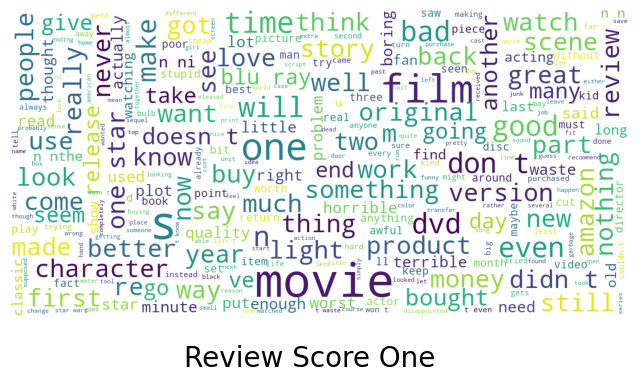

In [182]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

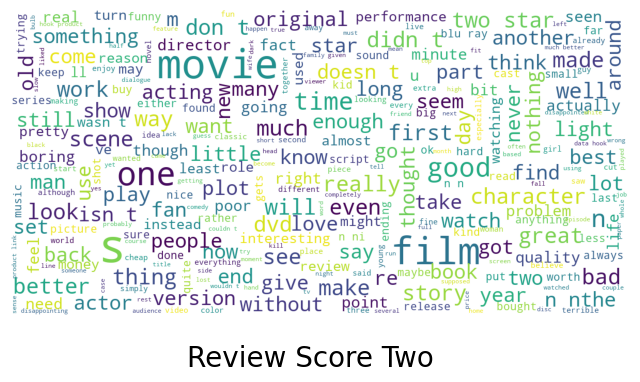

In [183]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

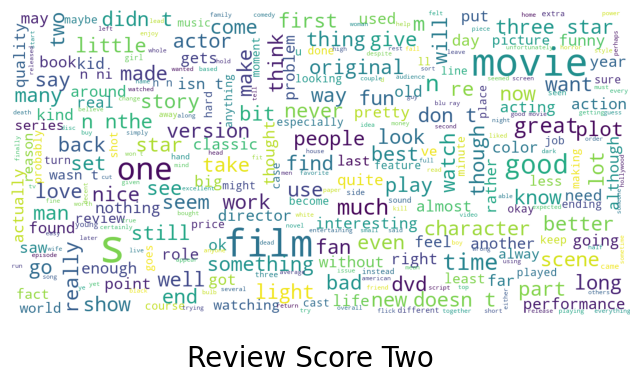

In [184]:
show_wordcloud(cluster1["summaryClean"][2] , title = "Review Score Two")

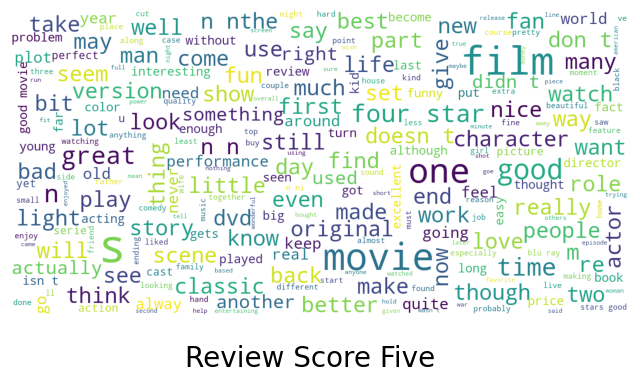

In [185]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Five")

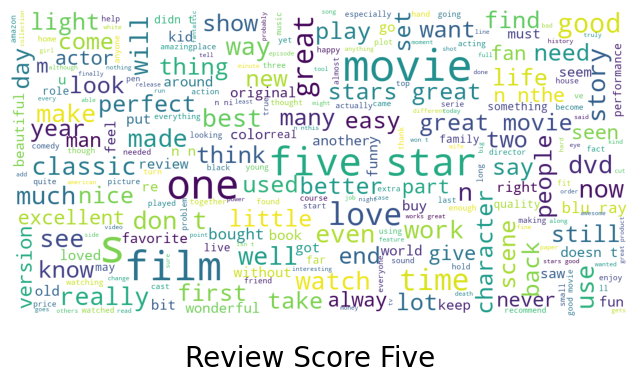

In [186]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")